Consolidate the folds into a single set of results.

In particular, compute the mean and standard deviations of the models in the accuracy, recall and F-score. 

In [17]:
import os
from glob import glob

import numpy as np
import tensorflow as tf

import ScalableLib.classifier.Multiband as multiband
import ScalableLib.base.plot as plot


In [2]:
# To reset cuda
# sudo rmmod nvidia_uvm
# sudo modprobe nvidia_uvm
# To see if the system regognises the GPU
device = 0
devices = tf.config.experimental.list_physical_devices('GPU')
tf.config.set_visible_devices(devices[device], 'GPU')
tf.config.experimental.set_memory_growth(device=devices[device], enable=True)


Read the Results folder.

In [3]:
survey = 'Gaia'
path = os.path.join('../../03_TrainModels/', survey, 'Results/Fold_*',)
folds = glob(path)
folds.sort()
folds

['../../03_TrainModels/Gaia/Results/Fold_1',
 '../../03_TrainModels/Gaia/Results/Fold_2',
 '../../03_TrainModels/Gaia/Results/Fold_3',
 '../../03_TrainModels/Gaia/Results/Fold_4',
 '../../03_TrainModels/Gaia/Results/Fold_5',
 '../../03_TrainModels/Gaia/Results/Fold_6',
 '../../03_TrainModels/Gaia/Results/Fold_7']

In [9]:
folder_name = 'Results'
path = os.path.join('.', folder_name,'')
if not os.path.exists(path):
    os.mkdir(path)

For each fold, read the models and evaluate on the test set. Save the results

In [10]:
label_order = ['CEP', 'T2CEP', 'MIRA_SR','RRAB', 'RRC', 'DSCT_SXPHE']

In [11]:
# Containers to store the results
reports_folds = []
cm_folds = []
for fold in folds:
    tf.keras.backend.clear_session()
    # Set the fold path
    base_dir = fold+'/'
    
    # Get the last run
    path_runs_folder = os.path.join(base_dir, 'Models', '*')
    path_runs = glob(path_runs_folder)
    path_runs.sort()
    path_run = path_runs[-1]    
    
    path_preprocess = fold.replace('/03_TrainModels/', '/02_CreateRecords/').replace('/'+folder_name+'/', '/Folds/')
    test_files = os.path.join(path_preprocess, 'test/*.tfrecord')
    path_preprocess = os.path.join(path_preprocess, 'metadata_preprocess.json')    

    
    new = multiband.Network()    
    settings_path = os.path.join(path_run, 'all_settings.json')

    fold_name = fold.split('/')[-1]
    write_path = os.path.join('./'+folder_name, fold_name+'_Results.dat')
    
    # Get weights path
    run = path_run.split('/')[-1]
    weights_path = os.path.join(fold, 'Models', run)
    new.run_test(settings_path, test_files, weights_path, df_paths = write_path);
    
    result_path = os.path.join('./'+folder_name, fold.split('/')[-1]+'_Results.dat')
    
    # From the results file, read the data and compute the classification scores
    report_fold = plot.compute_classification_report(result_path)
    reports_folds.append(report_fold)
    # From the results file, read the data and compute the confussion matrix and the respective  labels 
    cm_fold = plot.compute_confussion_matrices(result_path, labels=label_order)
    cm_folds.append(cm_fold)


2024-08-29 12:54:08.773954: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 10272 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3080, pci bus id: 0000:02:00.0, compute capability: 8.6


../../02_CreateRecords/Gaia/Folds/Fold_1/test/*.tfrecord


2024-08-29 12:54:09.766417: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-08-29 12:54:23.799993: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904


              precision    recall  f1-score   support

         CEP       0.66      0.75      0.70      1166
  DSCT_SXPHE       0.81      0.61      0.69       680
     MIRA_SR       1.00      1.00      1.00      8000
        RRAB       0.87      0.90      0.89      8000
         RRC       0.78      0.74      0.76      3451
       T2CEP       0.63      0.45      0.52       236

    accuracy                           0.89     21533
   macro avg       0.79      0.74      0.76     21533
weighted avg       0.89      0.89      0.89     21533

../../02_CreateRecords/Gaia/Folds/Fold_2/test/*.tfrecord
              precision    recall  f1-score   support

         CEP       0.68      0.77      0.72      1166
  DSCT_SXPHE       0.84      0.61      0.71       680
     MIRA_SR       1.00      1.00      1.00      8000
        RRAB       0.87      0.90      0.89      8000
         RRC       0.79      0.73      0.76      3451
       T2CEP       0.62      0.44      0.52       236

    accuracy        

In [12]:
mean, std = plot.obtain_accumulated_metrics(reports_folds, metric='mean', label_order=label_order)
display(mean)
display(std)

,CEP,T2CEP,MIRA_SR,RRAB,RRC,DSCT_SXPHE
precision,0.67,0.62,1.0,0.87,0.78,0.81
recall,0.76,0.46,1.0,0.90,0.73,0.62
f1-score,0.71,0.53,1.0,0.89,0.76,0.70
support,1166.00,236.00,8000.0,8000.00,3451.00,680.00


,CEP,T2CEP,MIRA_SR,RRAB,RRC,DSCT_SXPHE
precision,0.006956,0.018907,0.000398,0.002713,0.003834,0.014580
recall,0.015054,0.025395,0.000432,0.003186,0.007249,0.010049
f1-score,0.006972,0.021866,0.000378,0.001899,0.003734,0.006125
support,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


<Figure size 640x480 with 0 Axes>

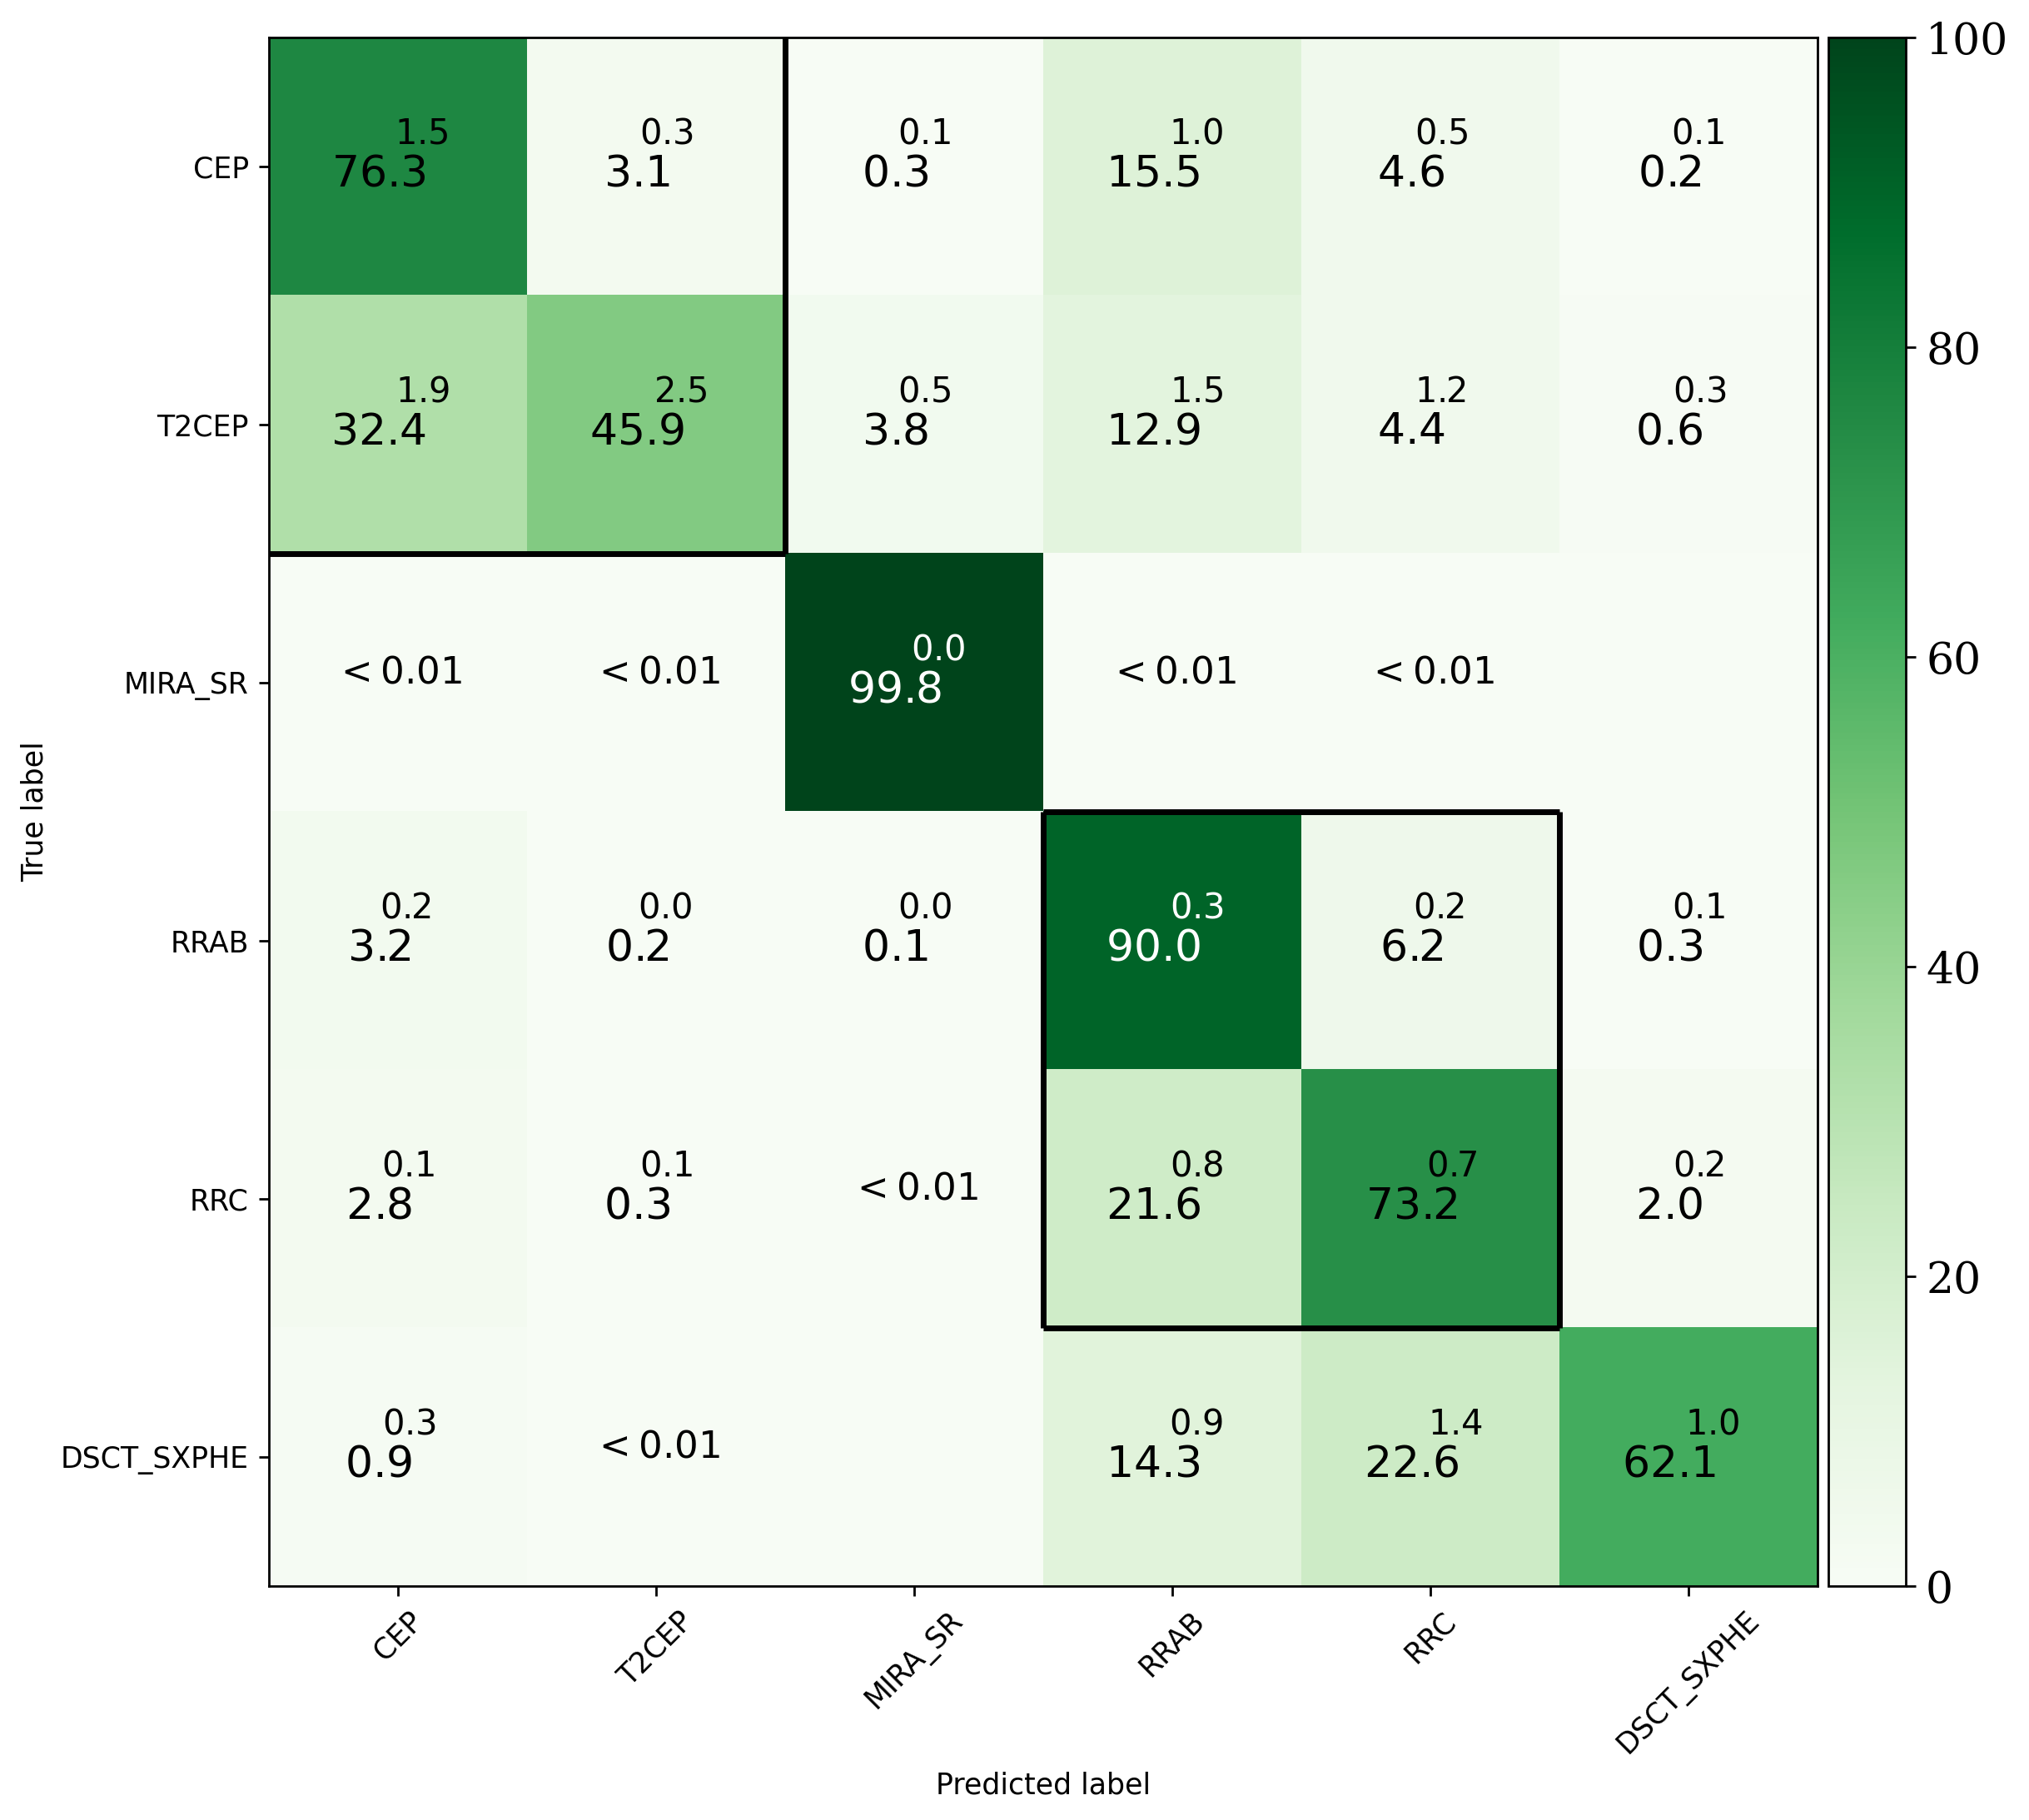

In [13]:
statistic = 'mean'
# survey = survey.replace('2','')
img_path = './'+survey+'_'+statistic+'_c.pdf'
plot.plot_confusion_matrix(cm_folds, labels_=label_order, survey='Gaia', statistic=statistic, save_path = img_path)

In [14]:
median, delta_up, delta_down = plot.obtain_accumulated_metrics(reports_folds, metric='median', label_order=label_order)
display(median)
display(delta_up)
display(delta_down)

,CEP,T2CEP,MIRA_SR,RRAB,RRC,DSCT_SXPHE
precision,0.67,0.62,1.0,0.87,0.78,0.81
recall,0.77,0.46,1.0,0.90,0.73,0.62
f1-score,0.71,0.52,1.0,0.89,0.76,0.70
support,1166.00,236.00,8000.0,8000.00,3451.00,680.00


,CEP,T2CEP,MIRA_SR,RRAB,RRC,DSCT_SXPHE
precision,0.007687,0.019451,0.000186,0.001859,0.002637,0.004773
recall,0.001715,0.006356,0.000187,0.001000,0.008403,0.008088
f1-score,0.005461,0.012326,0.000250,0.000832,0.001316,0.004924
support,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


,CEP,T2CEP,MIRA_SR,RRAB,RRC,DSCT_SXPHE
precision,0.000860,0.008850,0.000127,0.000358,0.002149,0.011174
recall,0.010292,0.014831,0.000375,0.003750,0.001449,0.005147
f1-score,0.004937,0.004741,0.000219,0.001545,0.002862,0.004546
support,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [19]:
np.round(median.loc['f1-score'].mean(),3)

0.763

<Figure size 640x480 with 0 Axes>

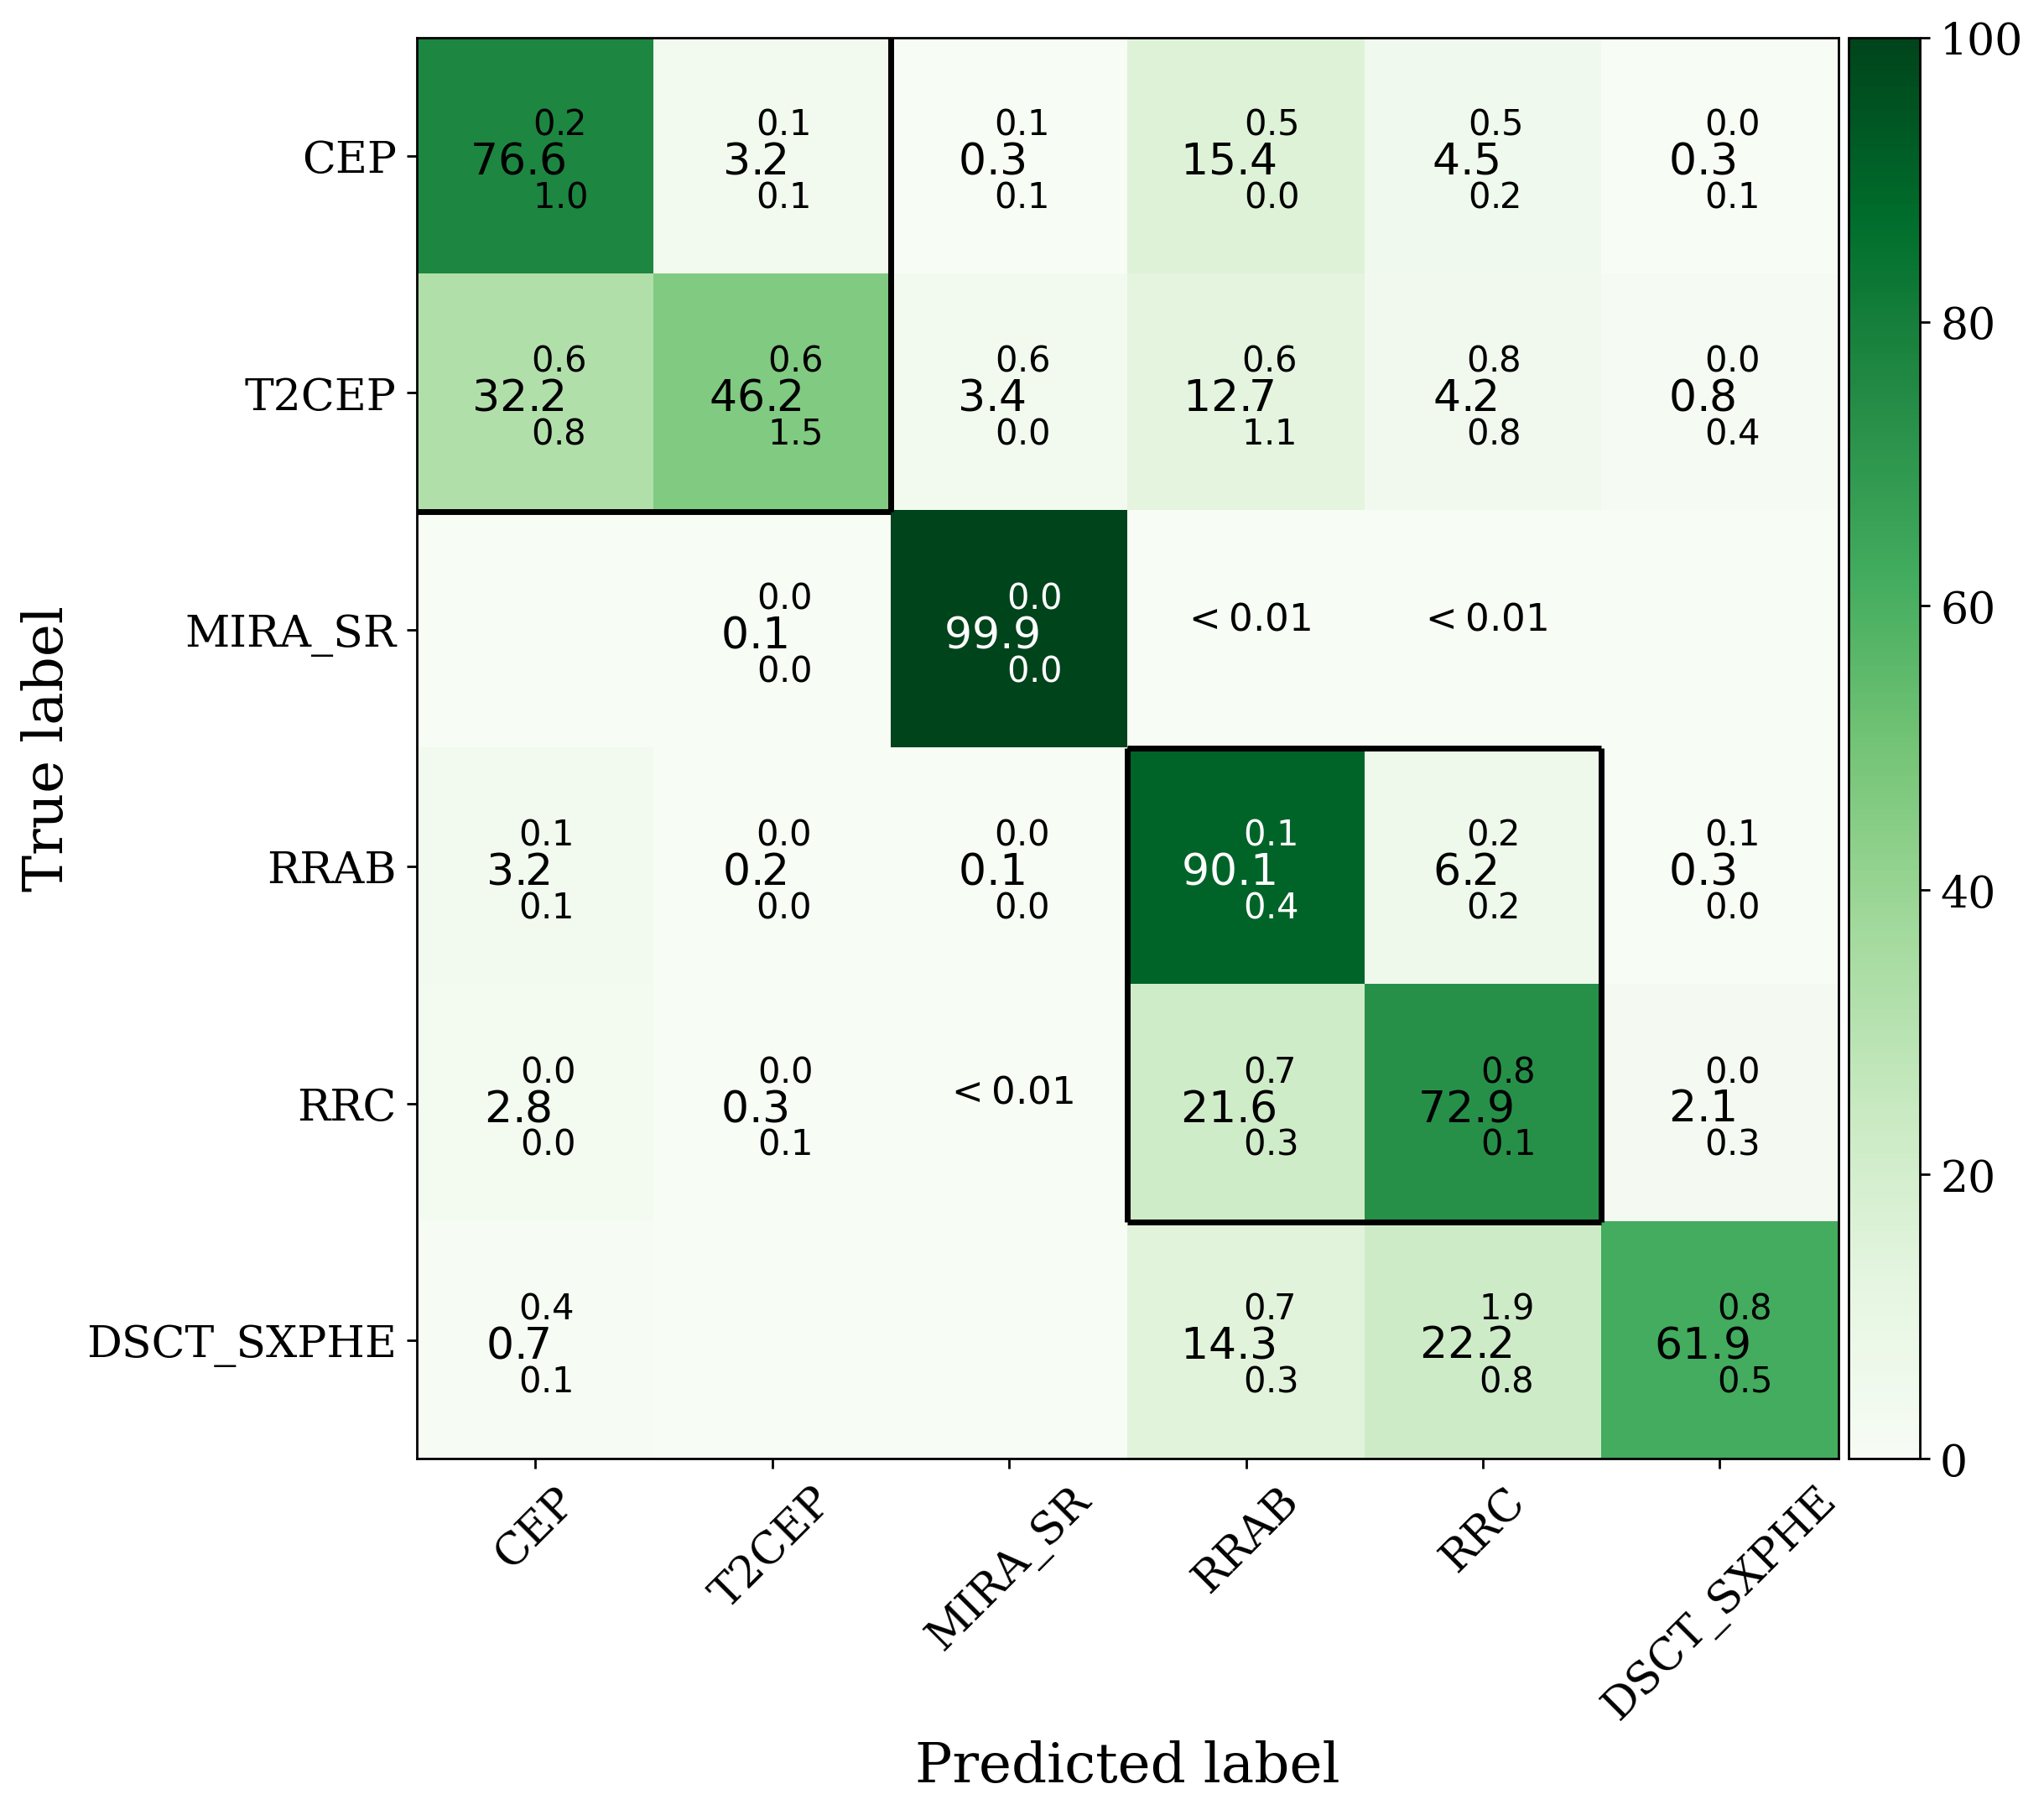

In [20]:

statistic = 'median'
img_path = './'+survey+'_'+statistic+'_c.pdf'
plot.plot_confusion_matrix(cm_folds, labels_=label_order, survey='Gaia', statistic=statistic, save_path=img_path)

Macro metrics

Accuracy

In [21]:
accuracies = [reports_folds[i]['accuracy'] for i in range(len(reports_folds))]
np.round(np.median(accuracies),4), np.round(np.mean(accuracies),4)


(0.8885, 0.8885)

Macro-avg recall

In [22]:
macro_avg_recall = [reports_folds[i]['macro avg']['recall'] for i in range(len(reports_folds))]
np.round(np.median(macro_avg_recall),4), np.round(np.mean(macro_avg_recall),4)

(0.745, 0.7454)